In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import requests
from bs4 import BeautifulSoup  # pip install bs4   (mac:pip->pip3)
from tqdm import tqdm_notebook # pip install tqdm  (mac:pip->pip3)

In [3]:
# Input : 本頁的 soup object
# Outpu : "上ㄧ頁"的網址 
def get_last_page_url(soup):
    for entry in soup.select('.btn'):
        if entry.text == '‹ 上頁':
            return ('https://www.ptt.cc' + entry['href'])

# Input : Ptt 上的推薦指數( X代表負評， 爆代表超過 100 推) 
# Output : 數字(-10 ~ 100)
def rec2int(rec):
    if rec=='爆' : 
        num_rec = 100 
    elif 'XX' in rec:
        return -100
    elif 'X' in rec:
        num_rec = -10 * int(rec.split('X')[1]) 
    elif not rec.strip():
        num_rec = 0
    else: 
        num_rec = int(rec)
    return num_rec

# Input : ㄧ個頁面的 soup object, 以及過濾標準(至少要幾推才要)
# Output : 這個頁面所有符合標準文章的網址
def get_post_urls(soup, rec_lowbound=10):
    urls = []
    for entry in soup.select('.r-ent'):
        rec = entry.select('.nrec')[0].text
        num_rec = rec2int(rec)
        if(num_rec >= rec_lowbound and '[公告]' not in entry.select('.title')[0].text):
            if(entry.select('.title')[0].a):
                url = 'https://www.ptt.cc' + entry.select('.title')[0].a['href']
                urls.append(url)
    return urls

# Input : ㄧ個文章頁面的 soup object
# Output : 這篇文的標題及文章
def get_article(soup, board='joke'):
    for entry in soup.select('#main-container'):
        title = entry.text.split('\n', 2)[1]
        if( len(title.split('看板'+board+'標題'))) < 2:
            return ('','')
        title = title.split('看板'+board+'標題')[1]
        title = title.rsplit('時間', 1)[0]
        content = entry.text.split('\n', 2)[2]
        content = content.split('※ 發信站: 批踢踢實業坊(ptt.cc)')[0]
        return (title, content)
    return ("","")

# Input : ㄧ個文章頁面的 soup object
# Output : 這篇文的推文

string_to_ingnore = ['ht', 'htt', 'https', 'jpg', 'imgur']

def get_push(soup):
    push_list = []
    for entry in soup.select('.push'):
        try:
            push_text = entry.text.split(':')[1].split('/')[0][:-2]
            for string in string_to_ingnore:
                push_text = push_text.replace(string, '')
            push_list.append(push_text)

        except:
            continue
    return push_list

In [4]:
# Input : 版名, 要爬幾頁的資料, 篩選標準, 需不需要爬推文, 是不是只回傳推文
# Output : 所有符合條件的文章

def get_articles(board='joke', n_pages=10, rec_lowbound=10, end_char = '➲'):
    res = requests.get('https://www.ptt.cc/bbs/'+board+'/index.html', verify=False)
    soup = BeautifulSoup(res.text)
    articles = []
    pbar = tqdm_notebook(total=n_pages)
    for i in range(n_pages):
        last_page_url = get_last_page_url(soup)
        post_urls     = get_post_urls(soup, rec_lowbound)
        for url in post_urls:
            res = requests.get( url, verify=False)
            soup_post = BeautifulSoup(res.text)
            title, content = get_article(soup_post, board)
            
            article = title + '\n' + content + '\n' + end_char
            
            # only article
            article = ''.join(article)
            articles.append( article )
            
        res = requests.get(last_page_url , verify=False)
        soup = BeautifulSoup(res.text)
        pbar.set_description('# articles:%i'%(len(articles)))
        pbar.update()
    pbar.close()
    print('# articles:', len(articles))
    return articles


def get_articles_push(board='joke', n_pages=10, rec_lowbound=10, end_char = '➲' ):
    res = requests.get('https://www.ptt.cc/bbs/'+board+'/index.html', verify=False)
    soup = BeautifulSoup(res.text)
    articles = []
    pbar = tqdm_notebook(total=n_pages)
    for i in range(n_pages):
        last_page_url = get_last_page_url(soup)
        post_urls     = get_post_urls(soup, rec_lowbound)
        for url in post_urls:
            res = requests.get( url, verify=False)
            soup_post = BeautifulSoup(res.text)
            title, content = get_article(soup_post, board)
            
            push_list = get_push(soup_post)
            # only Push
            
            articles +=  push_list 
        res = requests.get(last_page_url , verify=False)
        soup = BeautifulSoup(res.text)
        pbar.set_description('# articles:%i'%(len(articles)))
        pbar.update()
    pbar.close()
    print('# articles:', len(articles))
    return articles

In [5]:
# Get articles & articles_push
# articles = get_articles(board='NCTU_TALK', n_pages=10, rec_lowbound=10, end_char = '➲')
articles_push = get_articles_push(board='NCTU_TALK', n_pages=10, rec_lowbound=10, end_char = '➲')



# articles: 943


In [6]:
# combine all text in articels push
chars = '\r'.join(articles_push)
print('# article:%i \n# chars:%i' %(len(articles_push), len(chars)))

# article:943 
# chars:12665


In [7]:
# Write to a txt file
text_file = open("Output.txt", "w", encoding='utf8')
text_file.write(chars)
text_file.close()

In [8]:
font = 'NotoSansMonoCJKtc-Regular.otf' 

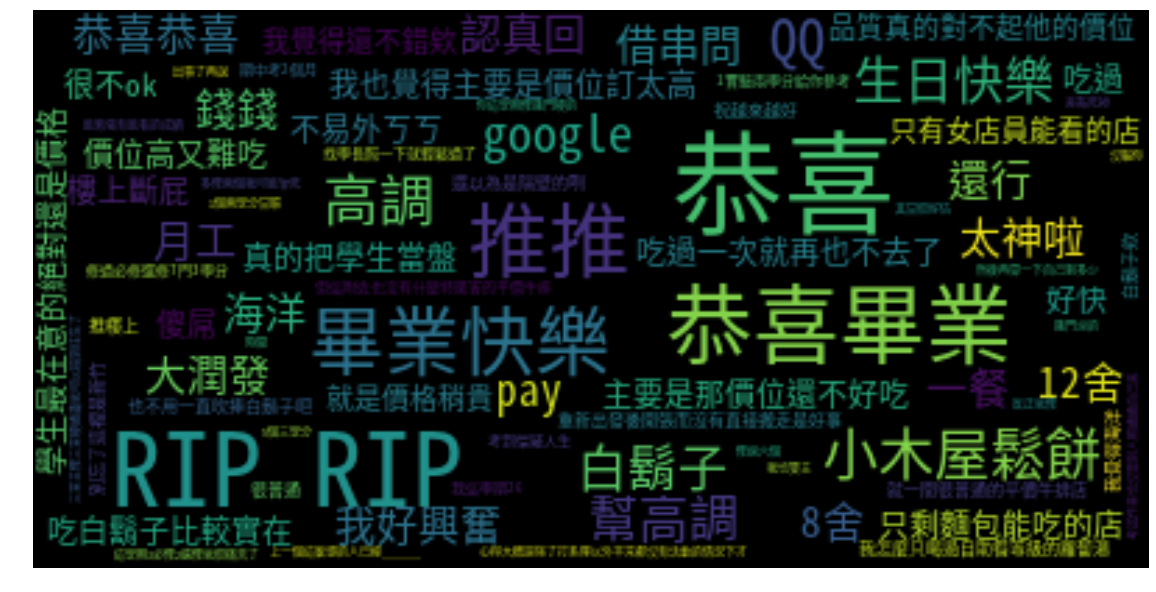

In [9]:
from wordcloud import WordCloud # pip install wordcloud (mac:pip->pip3)
text = open('Output.txt', encoding='utf8').read()

%matplotlib inline
import matplotlib.pyplot as plt

# lower max_font_size
wordcloud = WordCloud(max_font_size=40, font_path=font).generate(text)
plt.figure(figsize=(20, 30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()